In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.estela import Predictor
from teslakit.climate_emulator import Climate_Emulator
from teslakit.waves import AWL, TWL, AnnualMaxima, Aggregate_WavesFamilies, Intradaily_Hydrograph
from teslakit.util.time_operations import xds_limit_dates

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim
from teslakit.plotting.climate_emulator import Plot_Simulation
from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# Load data for climate emulator fitting: waves partitions and families, KMA, DWT

WVS_pts = db.Load_WAVES_partitions()       # waves partitions data (hourly)
WVS_pts = WVS_pts.rename({'hs':'Hs', 'tp':'Tp', 'dir':'Dir'})

WVS_fam = db.Load_WAVES_fams_noTCs()       # wave families sea, swell_1, swell_2 (TCs removed)


KMA = db.Load_ESTELA_KMA()                 # ESTELA predictor KMA

d_WT_TCs_wvs = db.Load_WAVES_fams_TCs_categ()  # TCs-window waves-families data by category

# prepare KMA data 
DWTs_fit = xr.Dataset(
    {
        'bmus'       : ('time', KMA['sorted_bmus_storms'].values[:] + 1),
        'cenEOFs'    : (('n_clusters', 'n_features',), KMA['cenEOFs'].values[:]),
    },
    coords = {'time' : KMA['time'].values[:]}
)


# --------------------------------------
# Load data for climate emulator simulation: ESTELA DWT and TCs (MU, TAU) 

DWTs_sim = db.Load_ESTELA_DWT_sim()

TCs_params = db.Load_TCs_r2_sim_params()    # TCs parameters (copula generated) 
TCs_RBFs = db.Load_TCs_sim_r2_rbf_output()  # TCs numerical_IH-RBFs_interpolation output

probs_TCs =  db.Load_TCs_probs_synth()      # TCs synthetic probabilities
pchange_TCs = probs_TCs['category_change_cumsum'].values[:]

l_mutau_wt = db.Load_MU_TAU_hydrograms()   # MU - TAU intradaily hidrographs for each WWT
MU_WT = np.array([x.MU.values[:] for x in l_mutau_wt])  # MU and TAU numpy arrays
TAU_WT = np.array([x.TAU.values[:] for x in l_mutau_wt])



## Climate Emulator - Fitting

In [4]:
# --------------------------------------
# Climate Emulator extremes model fitting

# climate emulator object
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

# Waves and KMA bmus data share time dimension
WVS_fam = WVS_fam.sel(time = DWTs_fit.time)
WVS_pts = WVS_pts.sel(time = DWTs_fit.time)

# Fit extremes model
config = {
    'name_fams':       ['sea', 'swell_1', 'swell_2'],
    'force_empirical': ['sea_Tp'],
}

CE.FitExtremes(DWTs_fit, WVS_pts, WVS_fam, config)

# Load Climate Emulator
#CE.Load()


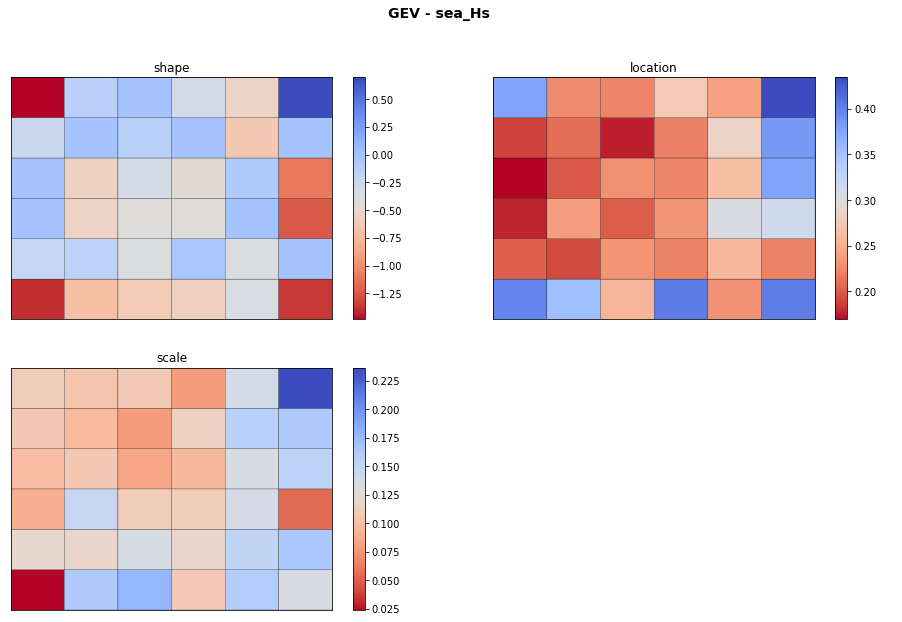

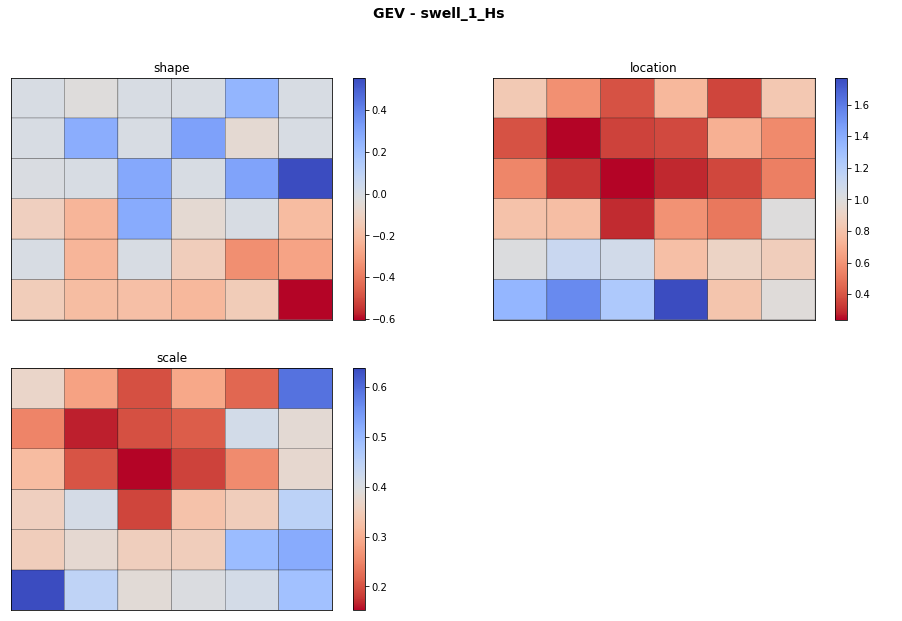

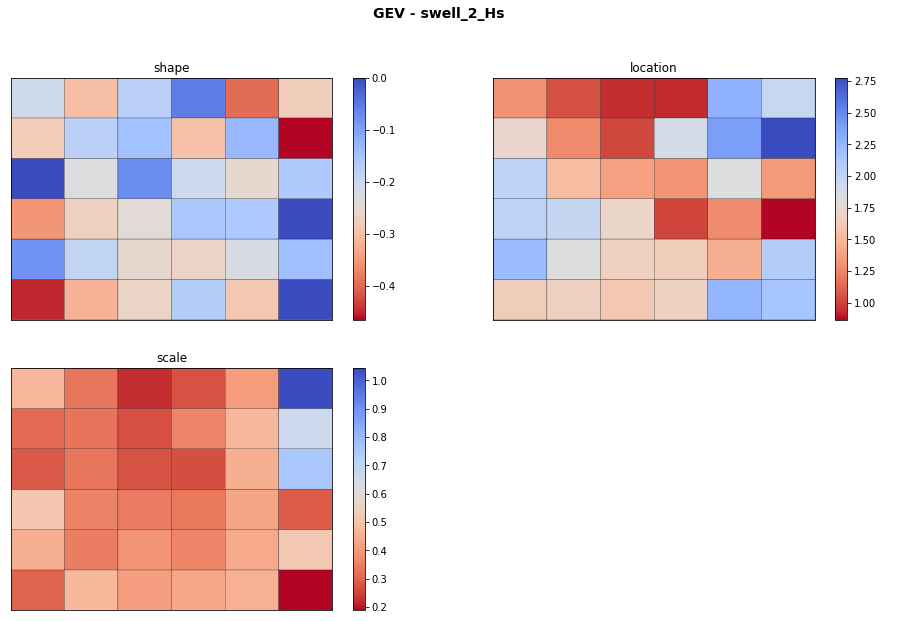

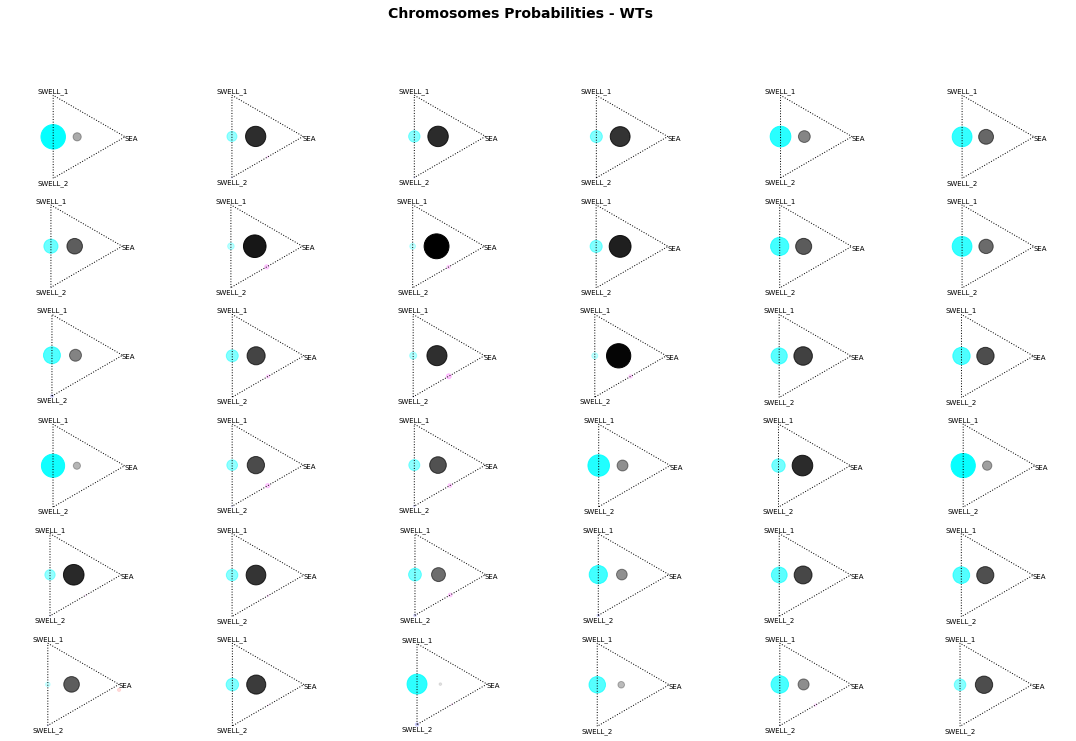

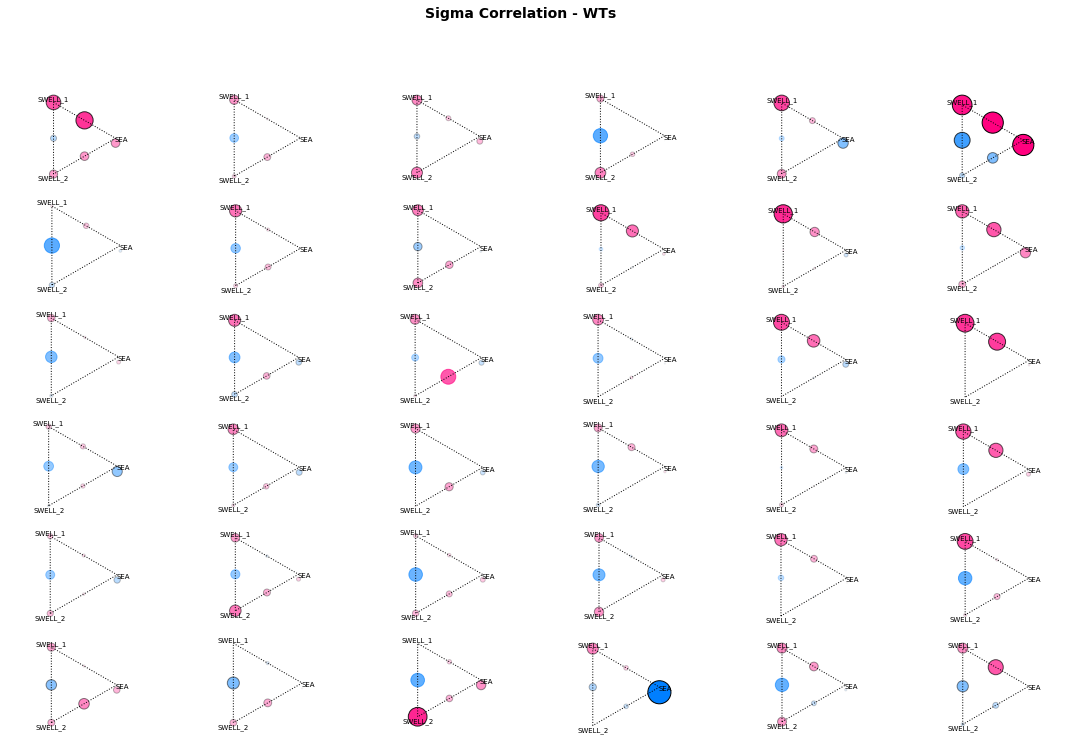

In [5]:
# Fit report figures
CE.Report_Fit();



## Climate Emulator - Simulation

In [6]:
# TODO: testing simulation period
#DWTs_sim = DWTs_sim.isel(time=slice(0,100*365), n_sim=slice(0,1))
DWTs_sim = DWTs_sim.isel(n_sim=slice(0,1))

print(DWTs_sim)


<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 91311)
Coordinates:
  * time         (time) datetime64[ns] 1700-01-01 1700-01-02 ... 1950-01-01
Dimensions without coordinates: n_sim
Data variables:
    evbmus_sims  (time, n_sim) float32 ...


In [7]:
# --------------------------------------
#  Climate Emulator simulation (NO TCs)

# Simulate waves
ls_wvs_sim = CE.Simulate_Waves(DWTs_sim, d_WT_TCs_wvs, do_filter=False)

# TODO problemas con el filtro?

# Simulate TCs and update simulated waves
ls_tcs_sim, ls_wvs_upd = CE.Simulate_TCs(DWTs_sim, d_WT_TCs_wvs, TCs_params, TCs_RBFs, pchange_TCs, MU_WT, TAU_WT)

#ls_wvs_upd, ls_tcs_sim = CE.LoadSim(TCs=True)


C.E: Sim. TCs  : 100%|██████████| 24745/24745 [00:01<00:00, 14752.37it/s]


In [8]:
# Select Simulation to solve
n_sim = 0

WVS_sim, TCS_sim = ls_wvs_upd[n_sim], ls_tcs_sim[n_sim]


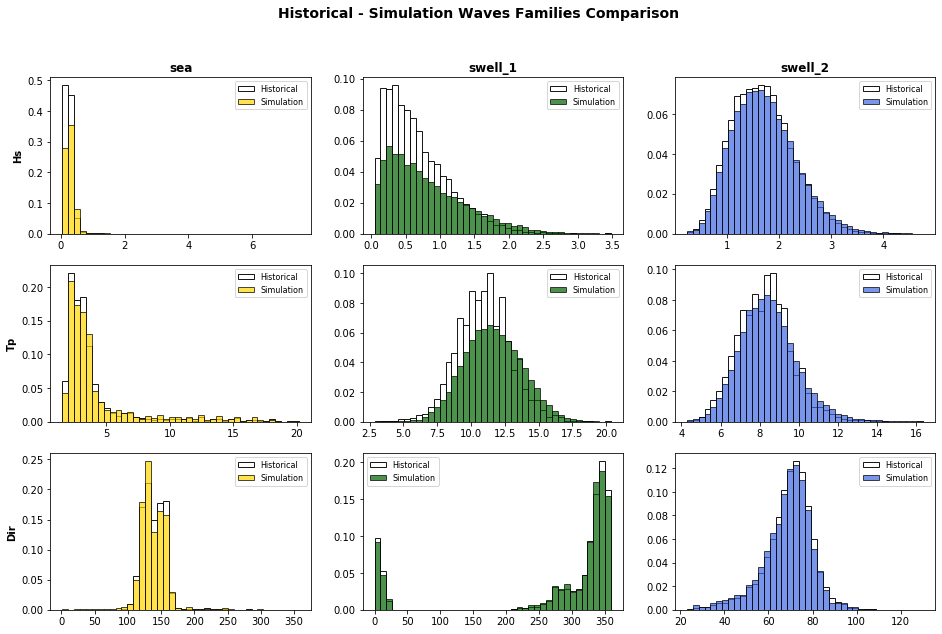

In [9]:
# Plot simulated waves parameters distribution 

Plot_Waves_Histogram_FitSim(WVS_fam, WVS_sim);
    


## Climate Emulator - Complete Output

In [10]:
# --------------------------------------
# Get all simulated data (hourly): AWTs, DWTs, MJO, MMSL, AT

DATA_sim_h = db.Load_SIM_hourly(n_sim_awt=0, n_sim_mjo=0, n_sim_dwt=0)

print(DATA_sim_h)


<xarray.Dataset>
Dimensions:  (time: 2191441)
Coordinates:
  * time     (time) datetime64[ns] 1700-01-01 1700-01-01T01:00:00 ... 1950-01-01
Data variables:
    AWT      (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 2 2 2 2 2 2 2 2 2 2 2 2
    MJO      (time) int64 23 23 23 23 23 23 23 23 23 ... 25 25 25 25 25 25 25 25
    DWT      (time) int64 35 35 35 35 35 35 35 35 35 ... 18 18 18 18 18 18 18 18
    MMSL     (time) float32 -0.007105551 -0.007105551 ... -0.099671654
    AT       (time) float32 -0.6416192 -0.51585776 ... -0.56447786 -0.78587514


In [11]:
# --------------------------------------
#  Complete simulation 

def Simulation_Hourly(wvs_sim, tcs_sim, data_sim):
    '''
    Generate hourly simulation output. 
    
    - aggregate simulated waves storms
    - generate hourly hydrographs
    - complete output data with simulated AWTs, MJO, DWTs, AT, MMSL
    - calculates AWL and TWL
    '''
    
    # Aggregate waves families data 
    wvs_agr = Aggregate_WavesFamilies(wvs_sim)
    
    # Calculate Intradaily hourly hydrographs for simulated storms
    hy = Intradaily_Hydrograph(wvs_agr, tcs_sim)
    

    # Complete simulation output 
    d1, d2 = xds_limit_dates([hy, data_sim])
    hy = hy.sel(time = slice(d1, d2))
    dd = data_sim.sel(time = slice(d1, d2))
    hy = xr.merge([hy, dd])
    
    
    # Calculate hourly Atmospheric Water Level and Total Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)
    hy['TWL'] = TWL(hy.AWL, hy.SS, hy.AT, hy.MMSL)

    return hy
    
    
# Generate simulated hourly data
SIM = Simulation_Hourly(WVS_sim, TCS_sim, DATA_sim_h)
    
print(SIM)
    

<xarray.Dataset>
Dimensions:  (time: 2191345)
Coordinates:
  * time     (time) datetime64[ns] 1700-01-01 1700-01-01T01:00:00 ... 1949-12-28
Data variables:
    Hs       (time) float64 1.307 1.334 1.362 1.389 ... 1.255 1.255 1.255 1.255
    Tp       (time) float64 10.36 10.36 10.36 10.36 ... 7.743 7.743 7.743 7.656
    Dir      (time) float64 59.15 59.15 59.15 59.15 ... 53.59 53.59 53.59 58.74
    SS       (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    AWT      (time) int64 5 5 5 5 5 5 5 5 5 5 5 5 5 ... 2 2 2 2 2 2 2 2 2 2 2 2
    MJO      (time) int64 23 23 23 23 23 23 23 23 23 ... 25 25 25 25 25 25 25 9
    DWT      (time) int64 35 35 35 35 35 35 35 35 35 ... 11 11 11 11 11 11 11 18
    MMSL     (time) float32 -0.007105551 -0.007105551 ... -0.0933663 -0.0933663
    AT       (time) float32 -0.6416192 -0.51585776 ... -0.4503084 -0.16039807
    AWL      (time) float64 0.636 0.6426 0.649 0.6554 ... 0.4658 0.4658 0.4606
    TWL      (time) float64 -0.01271 0.1196 0.

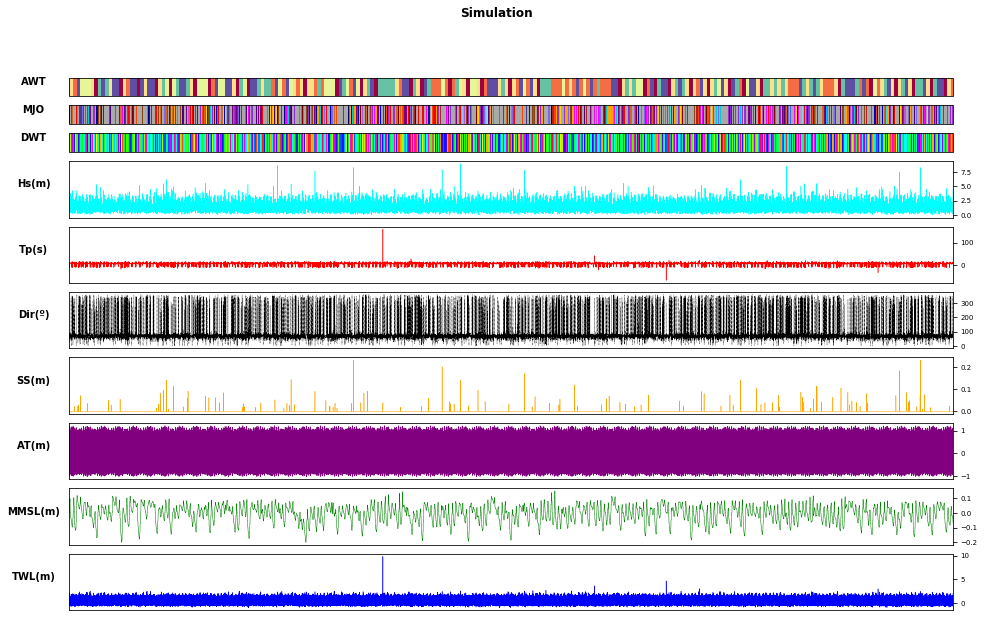

In [12]:
# Plot simulated output
Plot_Simulation(SIM);


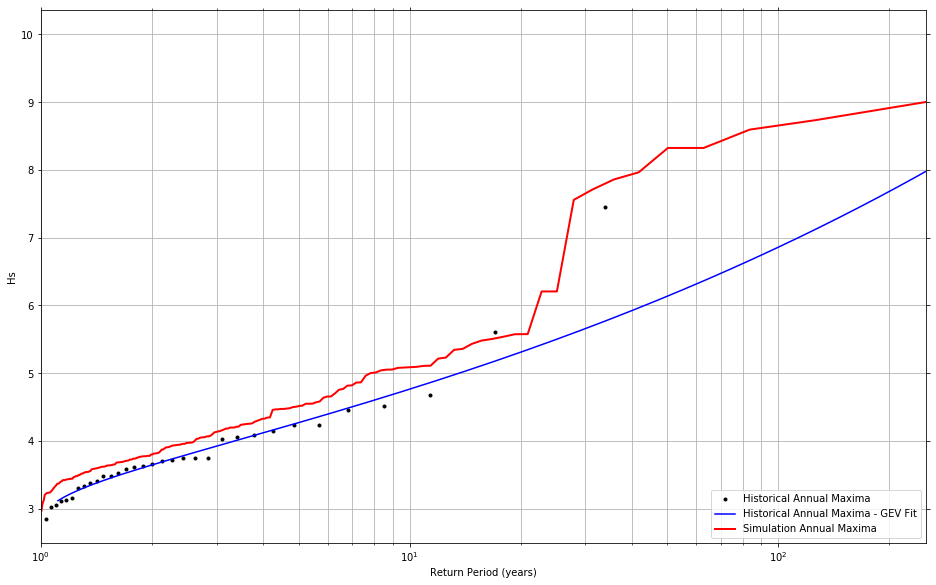

In [13]:
# --------------------------------------
#  Annual Maxima 
var_name = 'Hs'

# historical data (used to fit climate emulator)
hist_Amax = AnnualMaxima(CE.WVS_MS, var_name)

# simulation data
sim_Amax = AnnualMaxima(SIM, var_name)

# Plot Return Period
Plot_ReturnPeriodValidation(hist_Amax, sim_Amax, var_name);


In [14]:
# TODO: scatter plot Annual Maxima Fit vs Annual Maxima Simulated for all variables


